Cargando los datos y construyendo la serie de tiempo de Cuba

In [1]:
import json

with open("../data/covid19-cuba.json") as fp:
    data = json.load(fp)

cases_per_day = {k:len(v.get('diagnosticados', [])) for k,v in data['casos']['dias'].items()}

ts_cuba = []

t = 0
for _,v in cases_per_day.items():
    t += v
    ts_cuba.append(t)
    
ts_cuba

[3, 3, 4, 4, 4, 5, 7, 11, 16, 25, 35, 40, 48, 57, 67, 80]

Cargando los datos de los demás países (vienen en el mismo formato que tenemos antes)

In [2]:
with open("../data/paises-info-dias.json") as fp:
    countries_data = json.load(fp)

Esta función calcula una "similaridad" entre par de series, la de Cuba, y otra objetivo. En general se usa una media de error computando los residuales día a día y ponderándolos de cierta forma. Los parámetros son:

* `exponent`: $1, 2, ...$ es el exponente de la métrica, e.j., si es $2$ será un error cuadrático medio.
* `normalize`: determina si el residual de cada día se normaliza contra el valor de dicho día. Esto es para lograr, por ejemplo, que una diferencia entre $95$ y $100$ no sea considerada mayor que una diferencia entre $2$ y $4$. Si vale `False` se toman los residuales absolutos.

In [18]:
def similarity(country, exponent=1, normalize=True):
    min_len = min(len(ts_cuba), len(country))
    cuba = ts_cuba[0:min_len]
    country = country[0:min_len]
    
    def metric(vi, vj):
        t = abs(vi - vj)
        b = abs(vi) if normalize else 1
        return (t / b) ** exponent
    
    residuals = [metric(vi, vj) for vi,vj in zip(cuba, country)]
    msqe = sum(residuals) / len(residuals)
    
    return msqe

def sliding_similarity(country, exponent=1, normalize=True, window_size=15):
    min_sim = 1e50
    
    for i in range(window_size+1):
        sample = country[i:]
        
        if len(sample) >= len(ts_cuba):
            min_sim = min(min_sim, similarity(sample, exponent, normalize))
    
    return min_sim

### Paises

In [19]:
import pandas as pd

countries_stats = pd.read_csv("../data/world_demographics.tsv", sep="\t")
countries_stats

,Country,Population,Yearly change,Net change,Density,Land area,Migrants,Fertility,Med. age,Urban,World share
0,China,1439323776,0.39,5540090,153,9388211,-348399.0,1.7,38,61,18.47
1,India,1380004385,0.99,13586631,464,2973190,-532687.0,2.2,28,35,17.70
2,United States,331002651,0.59,1937734,36,9147420,954806.0,1.8,38,83,4.25
3,Indonesia,273523615,1.07,2898047,151,1811570,-98955.0,2.3,30,56,3.51
4,Pakistan,220892340,2.00,4327022,287,770880,-233379.0,3.6,23,35,2.83
...,...,...,...,...,...,...,...,...,...,...,...
230,Montserrat,4992,0.06,3,50,100,NaN,0.0,0,10,0.00
231,Falkland Islands,3480,3.05,103,0,12170,NaN,0.0,0,66,0.00
232,Niue,1626,0.68,11,6,260,NaN,0.0,0,46,0.00
233,Tokelau,1357,1.27,17,136,10,NaN,0.0,0,0,0.00


In [20]:
stats_dict = countries_stats.set_index('Country').to_dict('index')

In [21]:
def country_similarity(country):
    cuba_stats = stats_dict['Cuba']
    country_stats = stats_dict[country]
    
    similarity = []
    
    for key in ['Population', 'Density', 'Fertility', 'Med. age', 'Urban']:
        baseline = cuba_stats[key]
        value = abs(country_stats[key] - baseline)/baseline
        if value == 0:
            return 1e50
        similarity.append(value)
        
    return sum(similarity) / len(similarity)

all_similarities = {c: country_similarity(c) for c in stats_dict}
most_similar_countries = sorted(all_similarities, key=all_similarities.get)[:30]
most_similar_countries

['Hungary',
 'Portugal',
 'Austria',
 'United Arab Emirates',
 'Greece',
 'Belarus',
 'Costa Rica',
 'Slovakia',
 'Tunisia',
 'Azerbaijan',
 'Sweden',
 'Armenia',
 'Ireland',
 'Croatia',
 'North Macedonia',
 'Switzerland',
 'Jordan',
 'Finland',
 'Moldova',
 'Honduras',
 'Norway',
 'Brunei',
 'Cyprus',
 'Lithuania',
 'Bosnia and Herzegovina',
 'Chile',
 'Georgia',
 'Latvia',
 'New Zealand',
 'Montenegro']

Veamos ahora los países más "parecidos" a Cuba en términos **solamente** de la evolución actual. Nos fijaremos solo en aquellos que tengan al menos `k` días de predicciones más que Cuba.

In [23]:
exponent=1
normalize=True
window=15
k = 7
countries_to_analize = most_similar_countries

similarities = {
    name: (values, sliding_similarity(values, exponent, normalize, window)) 
    for name,values in countries_data['paises'].items() 
    if len(values) >= k + len(ts_cuba)
    if name in countries_to_analize
}

print("Cuba", "0", ts_cuba)

most_similar_curves = sorted(similarities.items(), key=lambda t: t[1][1])[:10] 

for i,(values, s) in most_similar_curves:
    print(i, s, values)

Cuba 0 [3, 3, 4, 4, 4, 5, 7, 11, 16, 25, 35, 40, 48, 57, 67, 80]
North Macedonia 0.23841685178856234 [1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 7, 7, 7, 14, 14, 14, 18, 26, 35, 48, 67, 85, 115, 136, 148]
Georgia 0.2713175158256904 [1, 1, 1, 1, 3, 3, 3, 3, 4, 4, 4, 13, 15, 15, 24, 24, 25, 30, 33, 33, 34, 38, 40, 43, 49, 54, 61, 70]
New Zealand 0.3325060334647677 [1, 1, 1, 1, 1, 3, 3, 4, 5, 5, 5, 5, 5, 5, 5, 6, 8, 8, 12, 20, 28, 39, 52, 102, 102, 155]
Latvia 0.34598127835276793 [1, 1, 1, 1, 1, 1, 2, 6, 8, 10, 10, 17, 26, 30, 34, 49, 71, 86, 111, 124, 139, 180, 197]
Lithuania 0.3910608148806548 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 6, 8, 12, 17, 25, 27, 36, 49, 83, 143, 179, 209]
Belarus 0.3919269324302955 [1, 1, 1, 1, 1, 6, 6, 6, 6, 6, 6, 9, 9, 12, 27, 27, 27, 36, 36, 51, 51, 69, 76, 76, 81, 81]
Greece 0.41703870907339574 [1, 3, 4, 4, 7, 7, 7, 9, 31, 45, 46, 73, 73, 89, 99, 99, 190, 228, 331, 331, 387, 418, 418, 495, 530, 624, 695, 743]
Azerbaijan 0.4254253297762724 [3, 3, 3, 3, 6, 6, 

### Forecast

Vamos a construir un modelo lineal basado en los días anteriores para predecir cada día posterior.
Los parámetros son:

* `step_back`: Cuantos días hacia atrás usar como variables características
* `skip_fraction`: Eliminar el primer $p$ porciento de los valores 
* `min_reports`: Cantidad mínima de reportes que debe haber en un día para usarlo
* `use_values`: Incluir los valores absolutos en las características
* `use_differences`: Incluir las diferencias entre cada par de días consecutivos en las características

In [24]:
steps_back = 10
skip_fraction = 0.1
min_reports = 5
use_values = True
use_diferences = False

In [25]:
import numpy as np

def _extract_features(serie, X=None, y=None):
    X = [] if X is None else X
    y = [] if y is None else y
    
    serie = serie[int(skip_fraction * len(serie)):]
    
    for i in range(steps_back, len(serie)):
        features = []
        
        if serie[i] < min_reports:
            continue      
            
        if use_values:
            features.extend(serie[i-steps_back:i])
        if use_diferences:
            for j in range(i-steps_back+1, i):
                features.append(serie[j] - serie[j-1])
            
        current = serie[i]
        
        X.append(features)
        y.append(current)
        
    return X, y

def extract_features(series):
    X = []
    y = []
    
    for country, serie in series.items():
        _extract_features(serie, X, y)
        
    return np.asarray(X), np.asarray(y)

X, y = extract_features({
    k:v[0] 
    for k,v in most_similar_curves
})

In [26]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split

In [27]:
def build_model():
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25)

    lr = Lasso(fit_intercept=False, positive=True, max_iter=10000, tol=0.001)
    lr.fit(Xtrain, ytrain)

    return lr

def predict(model, data, n, previous=1):
    data = list(data)
    result = []

    for i in range(n):
        data.append(data[-1])
        X, y = _extract_features(data)
        X = X[-previous:]

        ypred = model.predict(X)
        result.append(ypred[0])
        data[-1] = ypred[0]
        
    return result

In [28]:
lr = build_model()
predict(lr, ts_cuba, 7)

[94.82750602136427,
 112.40319872789847,
 133.23643755237995,
 157.93098855329293,
 187.20252209996747,
 221.89935364561555,
 263.0270286745806]

In [29]:
print(lr.coef_)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.18534383]


In [41]:
serie = ts_cuba
previous=1
simulations=15

Y = []
    
for i in range(30):    
    lr = build_model()
    yp = predict(lr, serie, n=simulations, previous=previous)
    yp.insert(0, serie[-previous])
    Y.append(yp)
    
Y = np.asarray(Y)

In [42]:
ymean = Y.mean(axis=0)
ystdv = Y.std(axis=0)

ymean, ystdv

for i, (x,s) in enumerate(zip(ymean, ystdv)):
    print("Day %i: %.0f (± %.0f @ 95%%)" % (i, x, 3*s))

Day 0: 80 (± 0 @ 95%)
Day 1: 94 (± 2 @ 95%)
Day 2: 110 (± 5 @ 95%)
Day 3: 130 (± 9 @ 95%)
Day 4: 152 (± 14 @ 95%)
Day 5: 179 (± 20 @ 95%)
Day 6: 210 (± 28 @ 95%)
Day 7: 247 (± 39 @ 95%)
Day 8: 291 (± 52 @ 95%)
Day 9: 342 (± 68 @ 95%)
Day 10: 401 (± 89 @ 95%)
Day 11: 472 (± 116 @ 95%)
Day 12: 555 (± 148 @ 95%)
Day 13: 652 (± 189 @ 95%)
Day 14: 767 (± 239 @ 95%)
Day 15: 901 (± 301 @ 95%)


In [43]:
from matplotlib import pyplot as plt

Ploteando la predicción para los próximos dias. La zona gris clara es el 95% de confianza y la zona gris oscura el 50% de confianza.

Text(0.5, 1.0, 'Cuba')

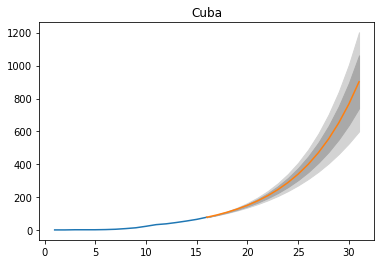

In [44]:
plt.plot(range(1, len(serie)+1), serie)
plt.plot(range(len(serie)+1-previous, len(serie)+1+len(ymean)-previous), ymean)
plt.fill_between(range(len(serie)+1-previous, len(serie)+1+len(ymean)-previous), 
                 ymean-ystdv*3, 
                 ymean+ystdv*3, 
                 color='lightgrey')
plt.fill_between(range(len(serie)+1-previous, len(serie)+1+len(ymean)-previous), 
                 ymean-ystdv*1.6, 
                 ymean+ystdv*1.6, 
                 color='darkgrey')
plt.title("Cuba")